In [ ]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


# LOAD PACKAGES and data

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss
from sklearn.preprocessing import StandardScaler

In [ ]:
dat = pd.read_csv("/content/2020_2024.csv")
dat.head()

,Date,EUR,USD,CNY,JPY,HKD,AUD,CAD,CHF,SGD,...,NZD,NOK,PLN,SAR,ZAR,SEK,TWD,THB,TRY,KRW
0,2020/1/2,1.1775,1.3189,9.1851,142.7973,10.2732,1.8833,1.7121,1.2783,1.7762,...,1.9647,11.5850,4.9990,4.9473,18.5279,12.3200,39.5828,39.7451,7.8481,1527.6291
1,2020/1/3,1.1710,1.3072,9.1045,141.2037,10.1654,1.8792,1.6971,1.2690,1.7632,...,1.9601,11.5272,4.9679,4.9046,18.6211,12.2766,39.2748,39.4317,7.8063,1523.3717
2,2020/1/6,1.1761,1.3159,9.1783,142.5514,10.2220,1.8978,1.7072,1.2748,1.7757,...,1.9726,11.5837,4.9837,4.9365,18.7312,12.3840,39.5849,39.6810,7.8580,1537.3133
3,2020/1/7,1.1778,1.3122,9.1123,142.5180,10.2045,1.9103,1.7078,1.2755,1.7729,...,1.9780,11.6197,4.9967,4.9226,18.7848,12.3988,39.4277,39.7925,7.8411,1532.0263
4,2020/1/8,1.1781,1.3099,9.0969,142.2944,10.1860,1.9109,1.7077,1.2711,1.7698,...,1.9742,11.6091,4.9962,4.9140,18.6504,12.3813,39.3717,39.7882,7.7936,1529.1511


In [ ]:
date = dat['Date'].apply(lambda x: pd.Timestamp(x))#把数据转换成时间

In [ ]:
dat.shape

(1115, 26)

In [ ]:
cols_to_normalize = dat.columns[1:]#从第一个变量开始
scaler = StandardScaler()#标准化
dat[cols_to_normalize] = scaler.fit_transform(dat[cols_to_normalize])

# 转换为长表形式
data_long = pd.melt(dat, id_vars=['Date'], var_name='Currency', value_name='Value')

In [ ]:
dat[cols_to_normalize].shape

(1115, 25)

In [ ]:
data_long['Date'] = data_long['Date'].apply(lambda x: pd.Timestamp(x))

In [ ]:
data_long['series'], _ = pd.factorize(data_long['Currency'])#因子化标签

In [ ]:
data_long['time_index'] = data_long.groupby('series').cumcount()#时间标签

In [ ]:
data_long.head()

,Date,Currency,Value,series,time_index
0,2020-01-02,EUR,0.854094,0,0
1,2020-01-03,EUR,0.614981,0,1
2,2020-01-06,EUR,0.802593,0,2
3,2020-01-07,EUR,0.865130,0,3
4,2020-01-08,EUR,0.876166,0,4


In [ ]:
data_long = data_long.astype(dict(series=str))

# Data processing

In [ ]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 30

training_cutoff = data_long["time_index"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data_long[lambda x: x.time_index <= training_cutoff],
    time_idx="time_index",
    target="Value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data_long.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["Value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)


In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, data_long, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

In [ ]:
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)#baseline loss

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more det

tensor(0.3181, device='cuda:0')

In [ ]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=10),
    optimizer="Adam",
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 2 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 2 steps due to diverging loss.
ERROR: Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
ERROR:lightning.pytorch.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO: Restoring states from the checkpoint path at /content/.lr_find_f5aa0980-acd9-46f9-92e0-cd32499c1a39.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f5aa0980-acd9-46f9-92e0-cd32499c1a39.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_f5aa0980-acd9-46f9-92e0-cd32499c1a39.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_f

suggested learning rate: None


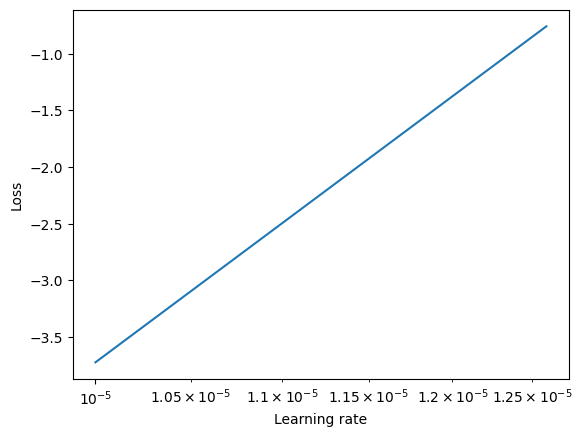

ERROR: Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
ERROR:lightning.pytorch.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


In [ ]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.035,
    hidden_size=64,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                   | Type                               | Params | Mode 
--------------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList                         | 0      | train
2 | embeddings             | MultiEmbedding                     | 250    | train
3 | rnn                    | LSTM                               | 53.0 K

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
currency = dat.columns[1:]
currency

Index(['EUR', 'USD', 'CNY', 'JPY', 'HKD', 'AUD', 'CAD', 'CHF', 'SGD', 'INR',
       'ILS', 'CZK', 'DKK', 'HUF', 'MYR', 'NZD', 'NOK', 'PLN', 'SAR', 'ZAR',
       'SEK', 'TWD', 'THB', 'TRY', 'KRW'],
      dtype='object')

In [ ]:
#best_model_path = trainer.checkpoint_callback.best_model_path
#best_model_path = "/content/lightning_logs/version_44/checkpoints/epoch=29-step=1500.ckpt"
best_model = DeepAR.load_from_checkpoint("/content/epoch=29-step=1500.ckpt")#选择最优模型
#print(best_model_path)
#best_model_path = "/content/lightning_logs/version_11/checkpoints/epoch=29-step=1500.ckpt"
#best_model_path = "/content/lightning_logs/version_44/checkpoints/epoch=29-step=1500.ckpt"
#/content/lightning_logs/version_53/checkpoints/epoch=29-step=1500.ckpt
#

In [ ]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(0.2207)

In [ ]:
numpy_data = predictions.output.numpy()
numpy_data.shape

(25, 30)

In [ ]:
a = scaler.inverse_transform(numpy_data.T)

In [ ]:
validation.data

{'reals': tensor([[0.9331],
         [0.5500],
         [1.3982],
         ...,
         [1.5661],
         [1.4439],
         [2.2668]]),
 'categoricals': tensor([[ 0],
         [ 0],
         [ 0],
         ...,
         [24],
         [24],
         [24]]),
 'groups': tensor([[ 0],
         [ 0],
         [ 0],
         ...,
         [24],
         [24],
         [24]]),
 'target': [tensor([0.6702, 0.6187, 0.7327,  ..., 1.5518, 1.5298, 1.6777])],
 'weight': None,
 'time': tensor([1025, 1026, 1027,  ..., 1112, 1113, 1114])}

In [ ]:

df = pd.DataFrame(a,columns=currency)
df.to_csv('pre.csv', index=False)

In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

NameError: name 'net' is not defined

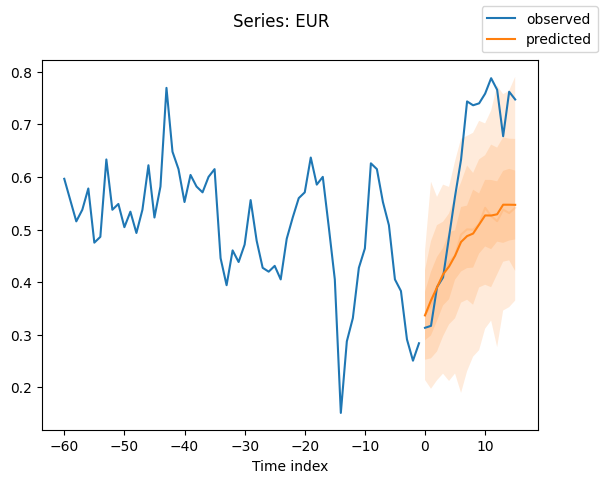

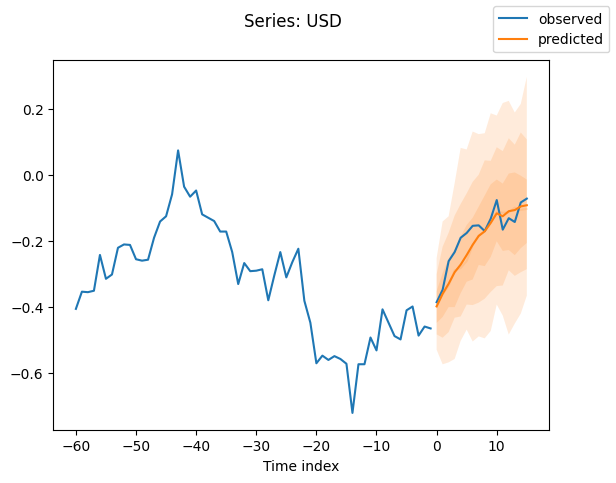

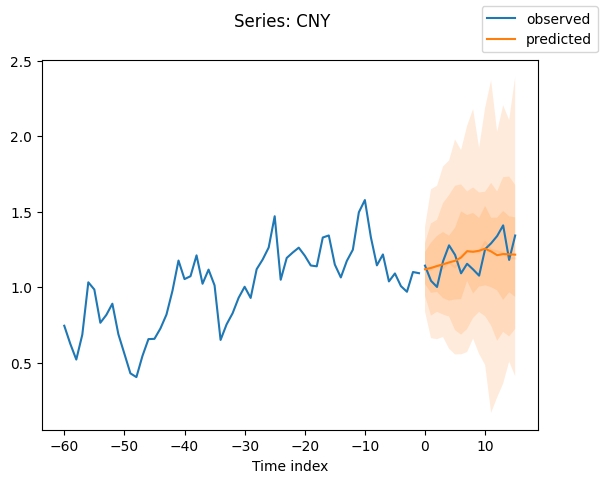

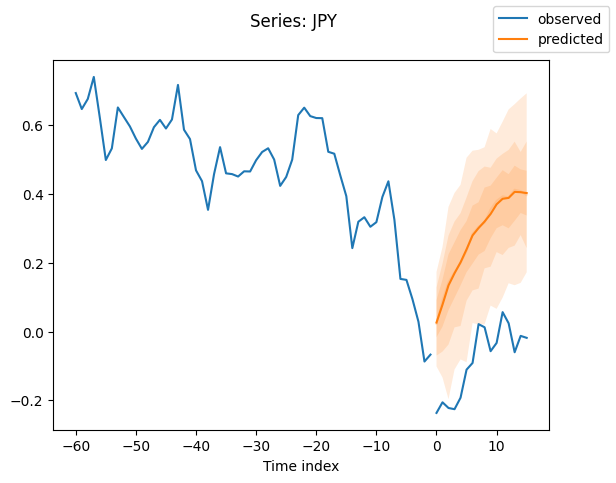

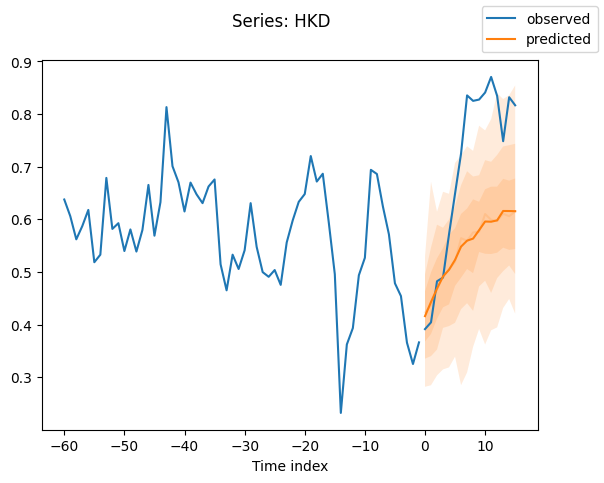

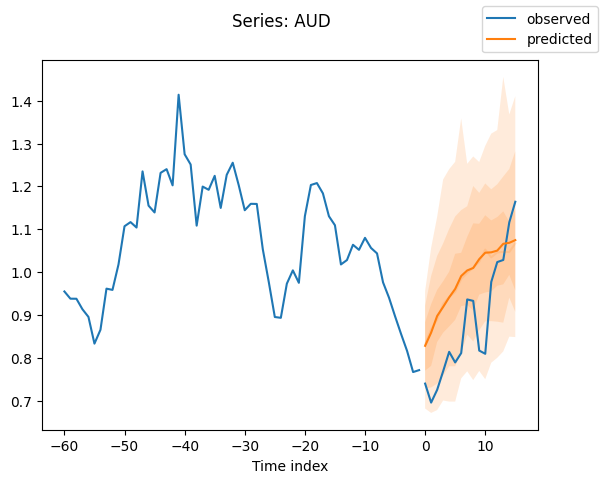

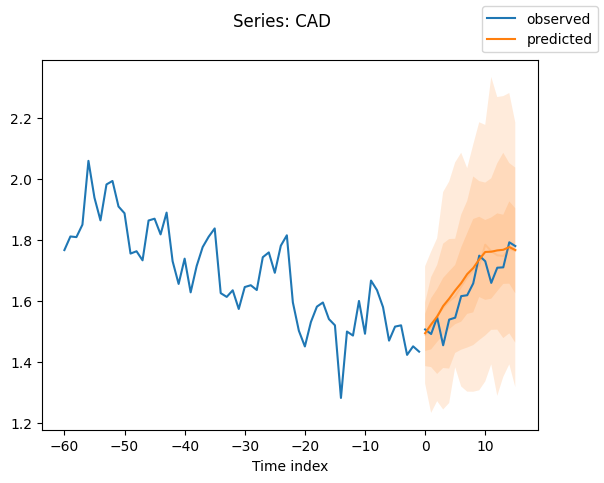

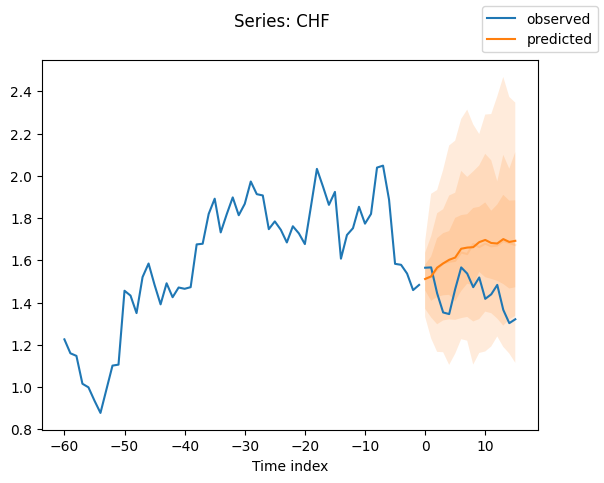

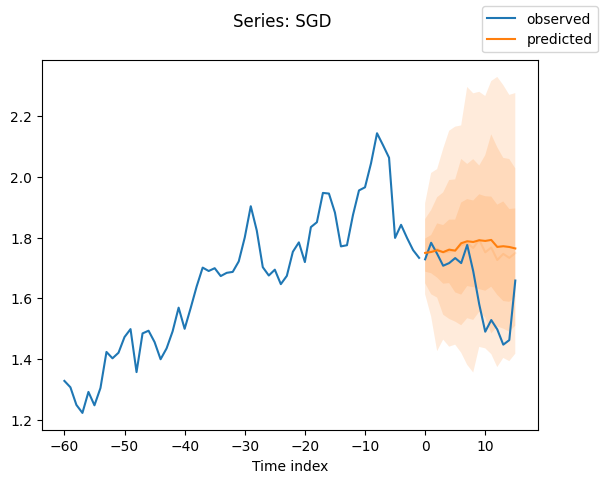

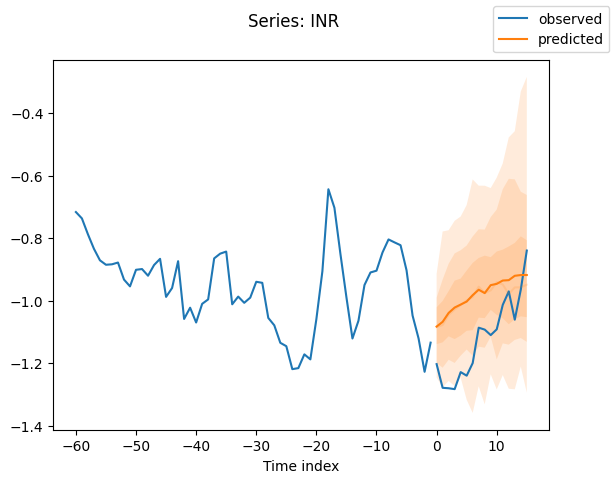

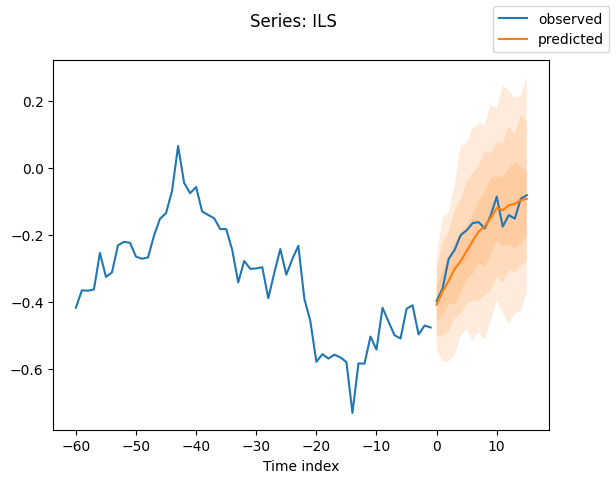

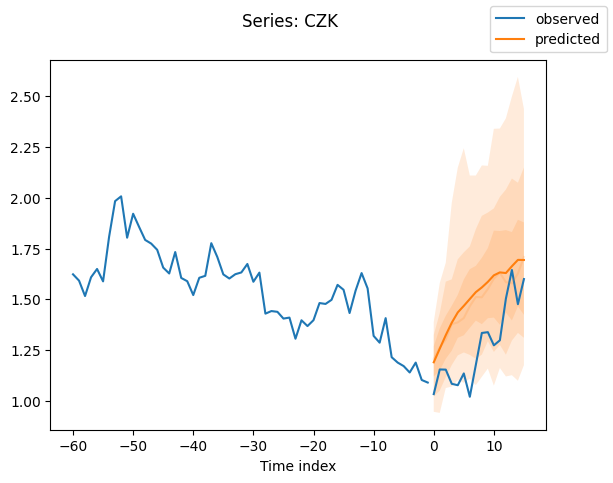

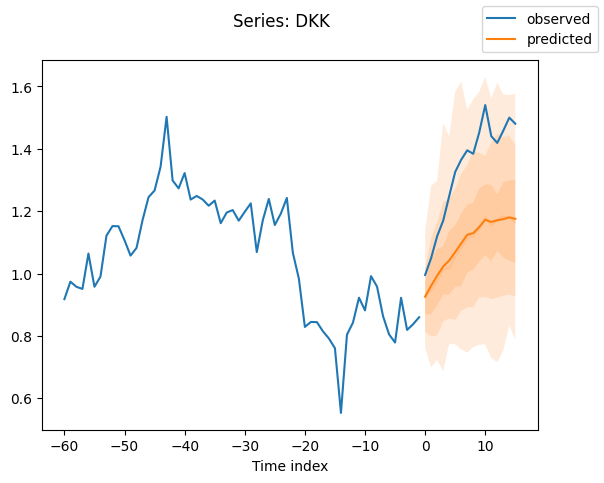

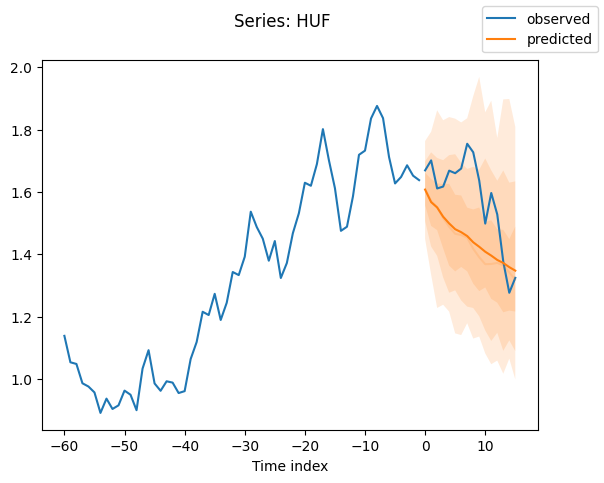

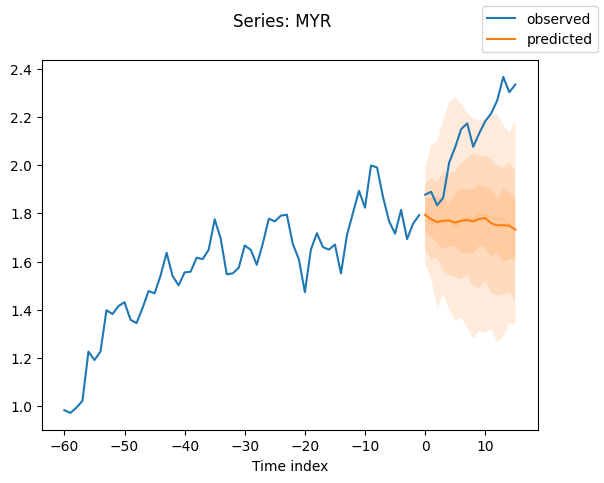

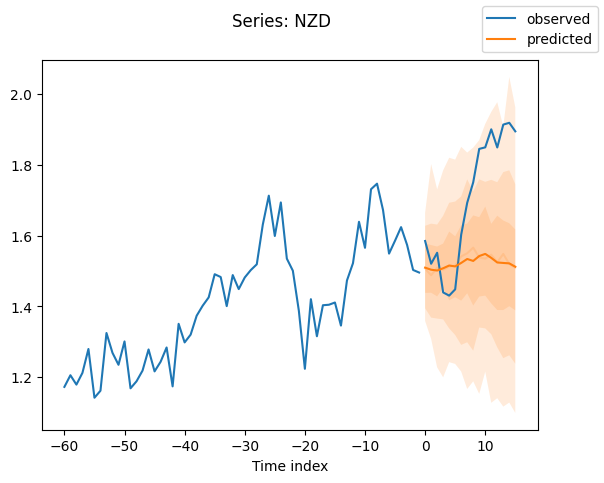

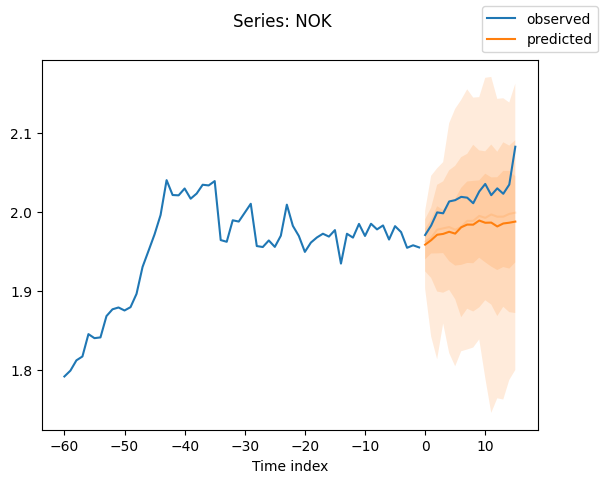

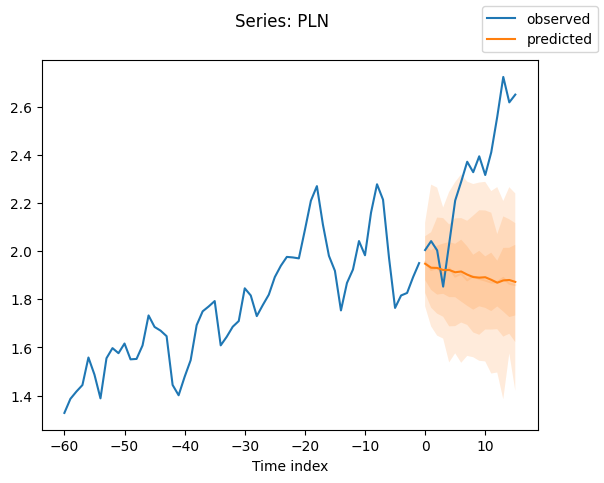

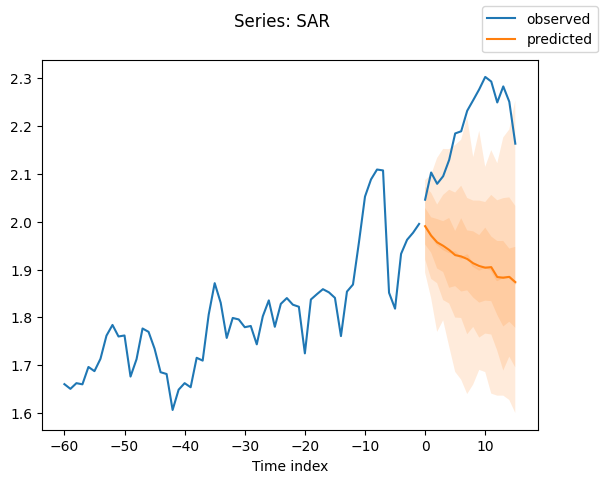

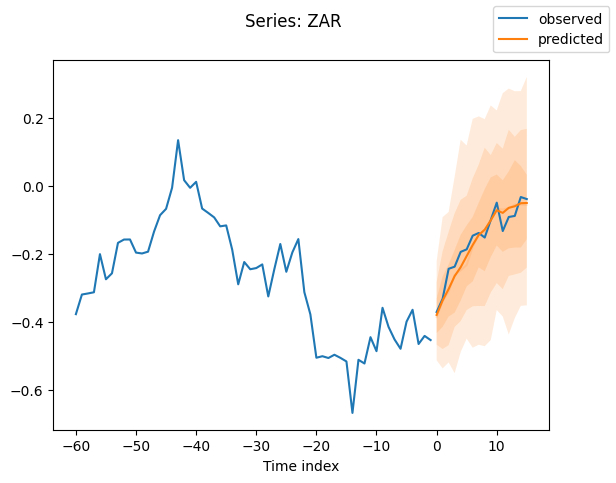

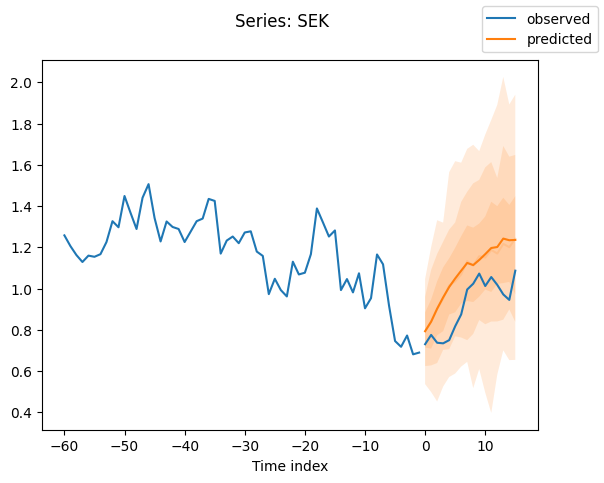

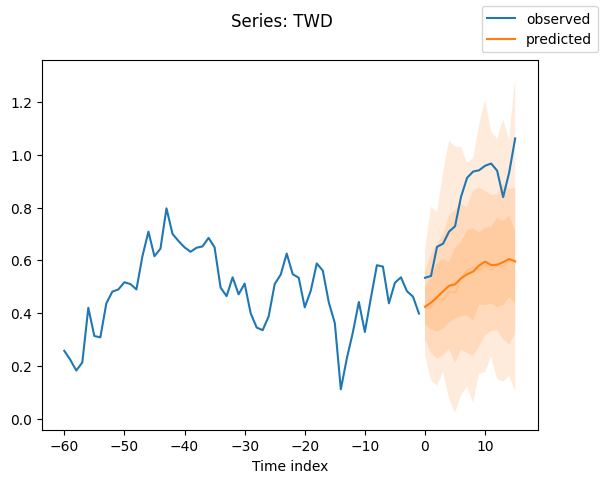

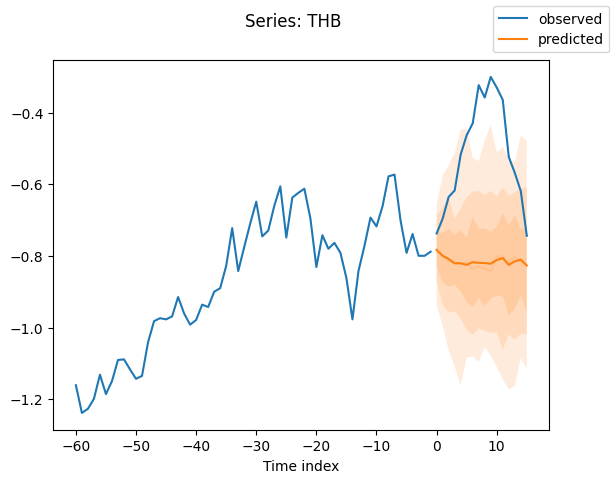

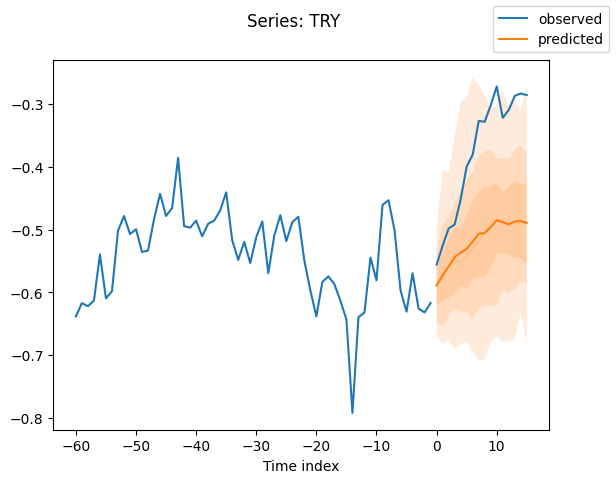

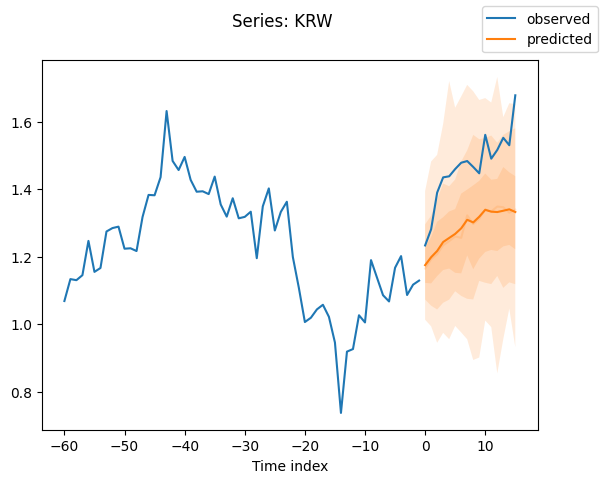

In [ ]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(25):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=False)
    plt.suptitle(f"Series: {currency[idx]}")

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


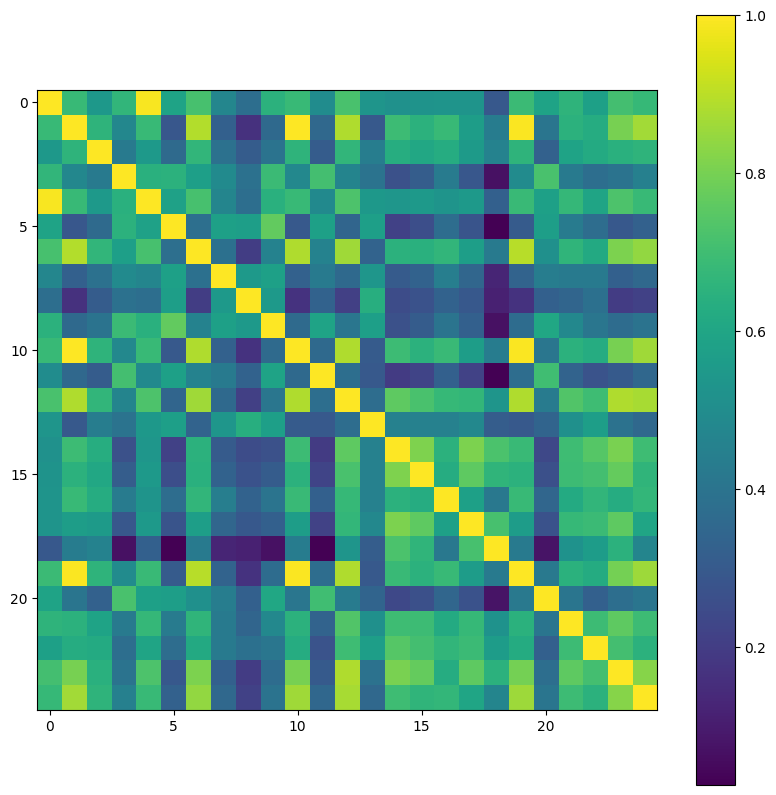

In [ ]:
cov_matrix = best_model.loss.map_x_to_distribution(
    best_model.predict(
        val_dataloader, mode=("raw", "prediction"), n_samples=None, trainer_kwargs=dict(accelerator="cpu")
    )
).base_dist.covariance_matrix.mean(0)

# normalize the covariance matrix diagnoal to 1.0
correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.imshow(correlation_matrix, cmap="bwr")
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# cax = ax.imshow(correlation_matrix, cmap="bwr", vmin=0, vmax=1)
# fig.colorbar(cax)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cax = ax.imshow(correlation_matrix, cmap="viridis")  # 使用 "viridis" 或其他合适的颜色映射
fig.colorbar(cax)

In [ ]:
cov_matrix

tensor([[0.6134, 0.2874, 0.2156, 0.3041, 0.6345, 0.2224, 0.3606, 0.1535, 0.1284,
         0.2878, 0.2859, 0.2698, 0.3090, 0.1631, 0.1751, 0.1904, 0.1229, 0.2106,
         0.1693, 0.2932, 0.4298, 0.2741, 0.1570, 0.4174, 0.2904],
        [0.2874, 0.2889, 0.1784, 0.1490, 0.2993, 0.0750, 0.3064, 0.0726, 0.0382,
         0.1086, 0.2864, 0.1310, 0.2608, 0.0626, 0.1609, 0.1617, 0.1091, 0.1541,
         0.1717, 0.2906, 0.2015, 0.1859, 0.1170, 0.3231, 0.2543],
        [0.2156, 0.1784, 0.2534, 0.1243, 0.2265, 0.0873, 0.2160, 0.0811, 0.0675,
         0.1130, 0.1776, 0.1072, 0.1841, 0.0862, 0.1372, 0.1414, 0.0941, 0.1421,
         0.1687, 0.1805, 0.1537, 0.1577, 0.1082, 0.2434, 0.1819],
        [0.3041, 0.1490, 0.1243, 0.3405, 0.3073, 0.1830, 0.2160, 0.1185, 0.0984,
         0.2280, 0.1498, 0.2846, 0.1495, 0.0905, 0.0669, 0.0837, 0.0744, 0.0853,
         0.0292, 0.1567, 0.3903, 0.1316, 0.0761, 0.1738, 0.1438],
        [0.6345, 0.2993, 0.2265, 0.3073, 0.6666, 0.2287, 0.3760, 0.1586, 0.1332,
       

In [ ]:
print(correlation_matrix.min(), correlation_matrix.max())

tensor(0.5047) tensor(1.)


(array([ 32.,   4.,  52., 146., 162., 112.,  46.,  28.,  10.,   8.]),
 array([0.50467998, 0.55383533, 0.60299075, 0.6521461 , 0.70130146,
        0.75045681, 0.79961222, 0.84876758, 0.89792293, 0.94707835,
        0.9962337 ]),
 <BarContainer object of 10 artists>)

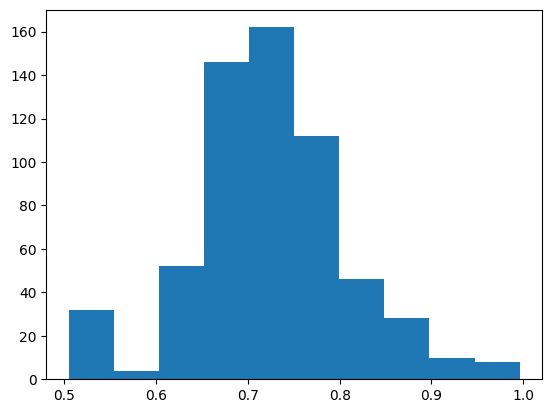

In [ ]:
plt.hist(correlation_matrix[correlation_matrix < 1].numpy())

In [ ]:
correlation_matrix # rho=0.604

tensor([[1.0000, 0.8532, 0.7140, 0.7820, 0.9895, 0.8126, 0.7931, 0.7258, 0.6915,
         0.8060, 0.8585, 0.6891, 0.8228, 0.7812, 0.7599, 0.7347, 0.7127, 0.7137,
         0.5234, 0.8615, 0.7603, 0.6898, 0.7101, 0.7467, 0.7968],
        [0.8532, 1.0000, 0.8009, 0.6822, 0.8429, 0.7101, 0.8939, 0.7459, 0.6714,
         0.7248, 0.9962, 0.6785, 0.8994, 0.6951, 0.8383, 0.7840, 0.7641, 0.7287,
         0.5203, 0.9952, 0.7537, 0.7135, 0.6520, 0.7840, 0.8966],
        [0.7140, 0.8009, 1.0000, 0.6515, 0.7032, 0.6863, 0.7822, 0.7197, 0.6828,
         0.6945, 0.8007, 0.6759, 0.8140, 0.7052, 0.7762, 0.7140, 0.7410, 0.6891,
         0.5424, 0.8001, 0.7187, 0.6693, 0.6619, 0.7179, 0.8256],
        [0.7820, 0.6822, 0.6515, 1.0000, 0.7732, 0.7778, 0.6951, 0.6836, 0.6559,
         0.7788, 0.6864, 0.7137, 0.7056, 0.7014, 0.6682, 0.6400, 0.6514, 0.6346,
         0.5354, 0.6894, 0.7539, 0.6141, 0.6484, 0.6452, 0.6928],
        [0.9895, 0.8429, 0.7032, 0.7732, 1.0000, 0.8046, 0.7861, 0.7159, 0.6833,
       

In [ ]:
!zip -r log.zip /content/lightning_logs


  adding: content/lightning_logs/ (stored 0%)
  adding: content/lightning_logs/version_51/ (stored 0%)
  adding: content/lightning_logs/version_51/events.out.tfevents.1722754633.d3e39a452e3a.454.51 (deflated 68%)
  adding: content/lightning_logs/version_51/hparams.yaml (deflated 60%)
  adding: content/lightning_logs/version_76/ (stored 0%)
  adding: content/lightning_logs/version_76/events.out.tfevents.1722755278.d3e39a452e3a.454.76 (deflated 68%)
  adding: content/lightning_logs/version_76/hparams.yaml (deflated 60%)
  adding: content/lightning_logs/version_58/ (stored 0%)
  adding: content/lightning_logs/version_58/hparams.yaml (deflated 60%)
  adding: content/lightning_logs/version_58/events.out.tfevents.1722754914.d3e39a452e3a.454.58 (deflated 68%)
  adding: content/lightning_logs/version_30/ (stored 0%)
  adding: content/lightning_logs/version_30/events.out.tfevents.1722753379.d3e39a452e3a.454.30 (deflated 68%)
  adding: content/lightning_logs/version_30/hparams.yaml (deflated 60%